# WALES Lidar

The water vapour differential absorption lidar WALES.
WALES operates at four wave-lengths near 935 nm to measure water-vapor mixing ratio profiles covering the whole atmosphere below the aircraft.
The system also contains additional aerosol channels at 532 nm and 1064 nm with depolarization.  WALES uses a high-spectral resolution technique, which distinguishes molecular from particle backscatter.

At typical flight speeds of 200 m/s the backscatter product from the HSRL has a resolution of 200m in the horizontal and 15m in the vertical, while the water vapor product has approximately 3km horizontal and 250m vertical. The PIs during EUREC4A were Martin Wirth and Heike Gross (DLR).

More information on the instrument can be found in [Wirth et al., 2009](https://elib.dlr.de/58175/). If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

```{note}
Due to safety regulations the Lidar can only be operated above 6 km which leads to data gaps in about the first and last 30 minutes of each flight.
```

In [1]:
import eurec4a
import xarray as xr

## Get data
To load the data we first load the EUREC4A meta data catalog and list the available datasets from WALES. 

More information on the catalog can be found [here](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue).

In [2]:
cat = eurec4a.get_intake_catalog()
print(cat.HALO.WALES.cloudparameter.description)

WALES-Lidar cloud top height, cloud optical thickness and cloud flag data.


## Cloud parameter

In [3]:
ds_cloud = cat.HALO.WALES.cloudparameter["HALO-0205"].to_dask()
ds_cloud

<xarray.Dataset>
Dimensions:     (time: 121200)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-05T09:34:00.167000064 ... 2020-...
    lat         (time) float32 ...
    lon         (time) float32 ...
Data variables:
    cloud_mask  (time) float32 ...
    cloud_top   (time) float32 ...
    cloud_ot    (time) float32 ...
    pbl_top     (time) float32 ...
    target_lat  (time) float64 ...
    target_lon  (time) float64 ...
Attributes: (12/24)
    convention:            CF-1.8
    location_name:         HALO
    platform:              HALO
    instrument:            WALES
    system:                WALES H2O-DIAL
    title:                 WALES lidar cloud mask
    ...                    ...
    ongoing_subset:        10
    featureType:           trajectory
    author:                Martin Wirth
    contact:               martin.wirth@dlr.de
    source:                airborne observation
    history:               2021-03-09 17:02:35 Generated by generate_cloudmas...

We select 1min of flight `time`. You can freely change the times or put `None` instead of the slice start and/or end to get up to the full flight data.
We explicitly `load()` the dataset at this stage as want to use this subset multiple times in the following.

```{note}
`load()` should always be called late and in particular after subsetting the data to prevent loading more than necessary.
```

In [4]:
ds_cloud_sel = ds_cloud.sel(time=slice("2020-02-05T13:06:30", "2020-02-05T13:07:030")).load()

In order to work with the different cloud mask flags, we extract the meanings into a dictionary, which we can later use to select relevant data:

In [5]:
cm_meanings = dict(zip(ds_cloud_sel.cloud_mask.flag_meanings.split(" "),
                       ds_cloud_sel.cloud_mask.flag_values))
cm_meanings

{'cloud_free': 0, 'probably_cloudy': 1, 'most_likely_cloudy': 2}

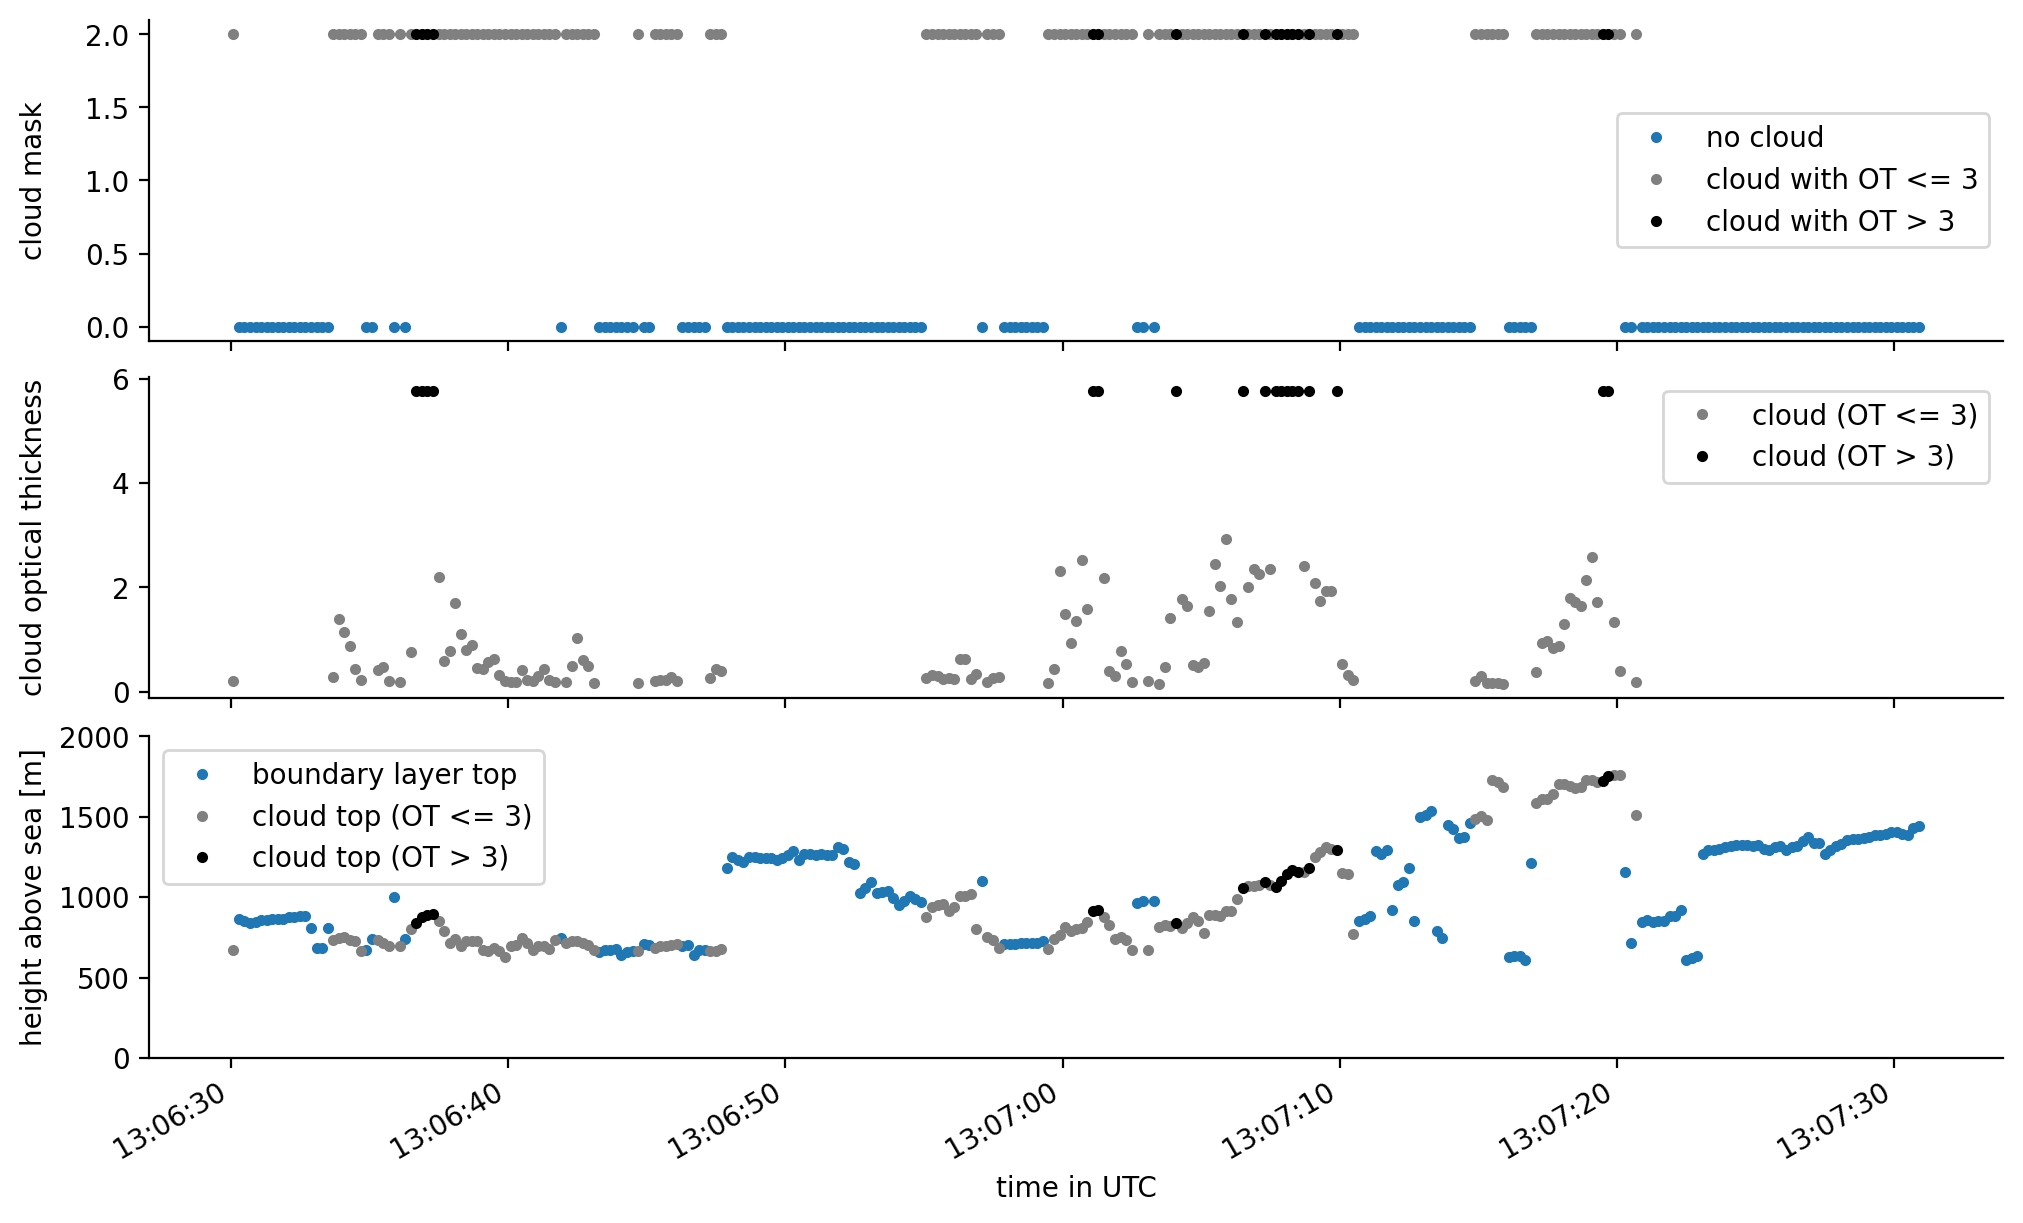

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("./mplstyle/book")

fig, axes = plt.subplots(3, 1, sharex=True)
ax1, ax2, ax3 = axes

cloud_free = ds_cloud_sel.cloud_mask[ds_cloud_sel.cloud_mask == cm_meanings["cloud_free"]]
cloud_free.plot(ax=ax1, x="time", ls="", marker=".", color="C0", label="no cloud")

thin_cloud = ds_cloud_sel.cloud_mask[ds_cloud_sel.cloud_ot<=3]
thin_cloud.plot(ax=ax1, x="time", ls="", marker=".", color="grey", label="cloud with OT <= 3")

thick_cloud = ds_cloud_sel.cloud_mask[ds_cloud_sel.cloud_ot>3]
thick_cloud.plot(ax=ax1, x="time", ls="", marker=".", color="k", label="cloud with OT > 3")

ax1.set_ylabel(f"{ds_cloud_sel.cloud_mask.long_name}")


ot_of_thin_cloud = ds_cloud_sel.cloud_ot[ds_cloud_sel.cloud_ot<=3]
ot_of_thin_cloud.plot(ax=ax2, x="time", ls="", marker=".", color="grey", label="cloud (OT <= 3)")

ot_of_thick_cloud = ds_cloud_sel.cloud_ot[ds_cloud_sel.cloud_ot>3]
ot_of_thick_cloud.plot(ax=ax2, x="time", ls="", marker=".", color="k", label="cloud (OT > 3)")

ax2.set_ylabel(f"{ds_cloud_sel.cloud_ot.long_name}")


pbl_top = ds_cloud_sel.pbl_top
pbl_top.plot(ax=ax3, x="time", ls="", marker=".", color="C0", label="boundary layer top")

thin_cloud_top = ds_cloud_sel.cloud_top[ds_cloud_sel.cloud_ot<=3]
thin_cloud_top.plot(ax=ax3, x="time", ls="", marker=".", color="grey", label="cloud top (OT <= 3)")

thick_cloud_top = ds_cloud_sel.cloud_top[ds_cloud_sel.cloud_ot>3]
thick_cloud_top.plot(ax=ax3, x="time", ls="", marker=".", color="k", label="cloud top (OT > 3)")

ax3.set_ylim(0, 2000)
ax3.set_ylabel("height above sea [m]")
ax3.set_xlabel('time in UTC')

for ax in axes:
    ax.label_outer()
    ax.legend()

fig.align_ylabels()
None

## Cloud fraction
The cloud fraction can be estimated based on how often the instrument detected a cloud versus how often it measured anything.
So, in order to compute the cloud fraction correctly, we must take care of missing values, in the original dataset.
As Python has no commonly used way of carrying on a missing value through comparisions, we must keep track of it ourselves.

```{note}
In contrary, the R language for example knows about the special value `NA` which is carried along through compatisons, such that the
result of the comparison `NA == 3` continues to be `NA`.

In Python and in particular using `xarray`, [missing data is expressed as `np.nan`](https://pandas.pydata.org/pandas-docs/version/0.19.2/gotchas.html#nan-integer-na-values-and-na-type-promotions), and due to floating point rules `np.nan == 3` evaluates to `False`.
As this `False` value is indistinguishable from a value which didn't match out flag (`3` in this case), averaging over the result
would lead to a wrong cloud fraction result.
```

To keep track of the missing data, we'll use `DataArray.where` on our boolean results to convert the results back to
floating-point numbers (`0` and `1`) and fill missing values back in as `np.nan`. Later on, methods like `.sum()` and `.mean()` will
automatically skip the `np.nan` values such that our results will be correct.
To finally compute the cloud fraction, we need some form of binary cloud mask, which contains values of either 0 or one.
To do so, we have two options, depending on whether we want to include `'probably_cloudy'` or not. These two options
are denoted by `min_` (without probably cloudy) and `max_` (with probably cloudy) prefixes.

In [7]:
cloudy_flags = xr.DataArray(
    [cm_meanings['probably_cloudy'], cm_meanings['most_likely_cloudy']],
    dims=("flags",))

min_cloud_binary_mask = (ds_cloud.cloud_mask == cm_meanings['most_likely_cloudy']).where(ds_cloud.cloud_mask.notnull())
max_cloud_binary_mask = (ds_cloud.cloud_mask == cloudy_flags).any("flags").where(ds_cloud.cloud_mask.notnull())
cloud_ot_gt3 = (ds_cloud.cloud_ot > 3).where(ds_cloud.cloud_ot.notnull())

print(f"Minimum cloud fraction on Feb 5: {min_cloud_binary_mask.mean().values * 100:.2f} %")
print(f"Total cloud fraction on Feb 5: {max_cloud_binary_mask.mean().values * 100:.2f} %")
print(f"Fraction of clouds with optical thickness greater than 3: {cloud_ot_gt3.mean().values * 100:.2f} %")

Minimum cloud fraction on Feb 5: 40.23 %
Total cloud fraction on Feb 5: 40.23 %
Fraction of clouds with optical thickness greater than 3: 28.25 %


As it turns out, in this section of the flight, the instrument is very certain about the cloudiness.
Yet, this missing value story was a bit complicated, so let's check if we would get something different if we would do it the naive way:

In [8]:
cf_wrong = (ds_cloud.cloud_mask == cloudy_flags).any("flags").mean().values
print(f"wrong cloud fraction: {cf_wrong * 100:.2f} %")

wrong cloud fraction: 39.93 %


Indeed, this is different... Good that we have thought about it.

We can now use a time averaging window to derive a time dependent cloud fraction from the `cloud_mask` variable and see how it varies over the course of the flight.

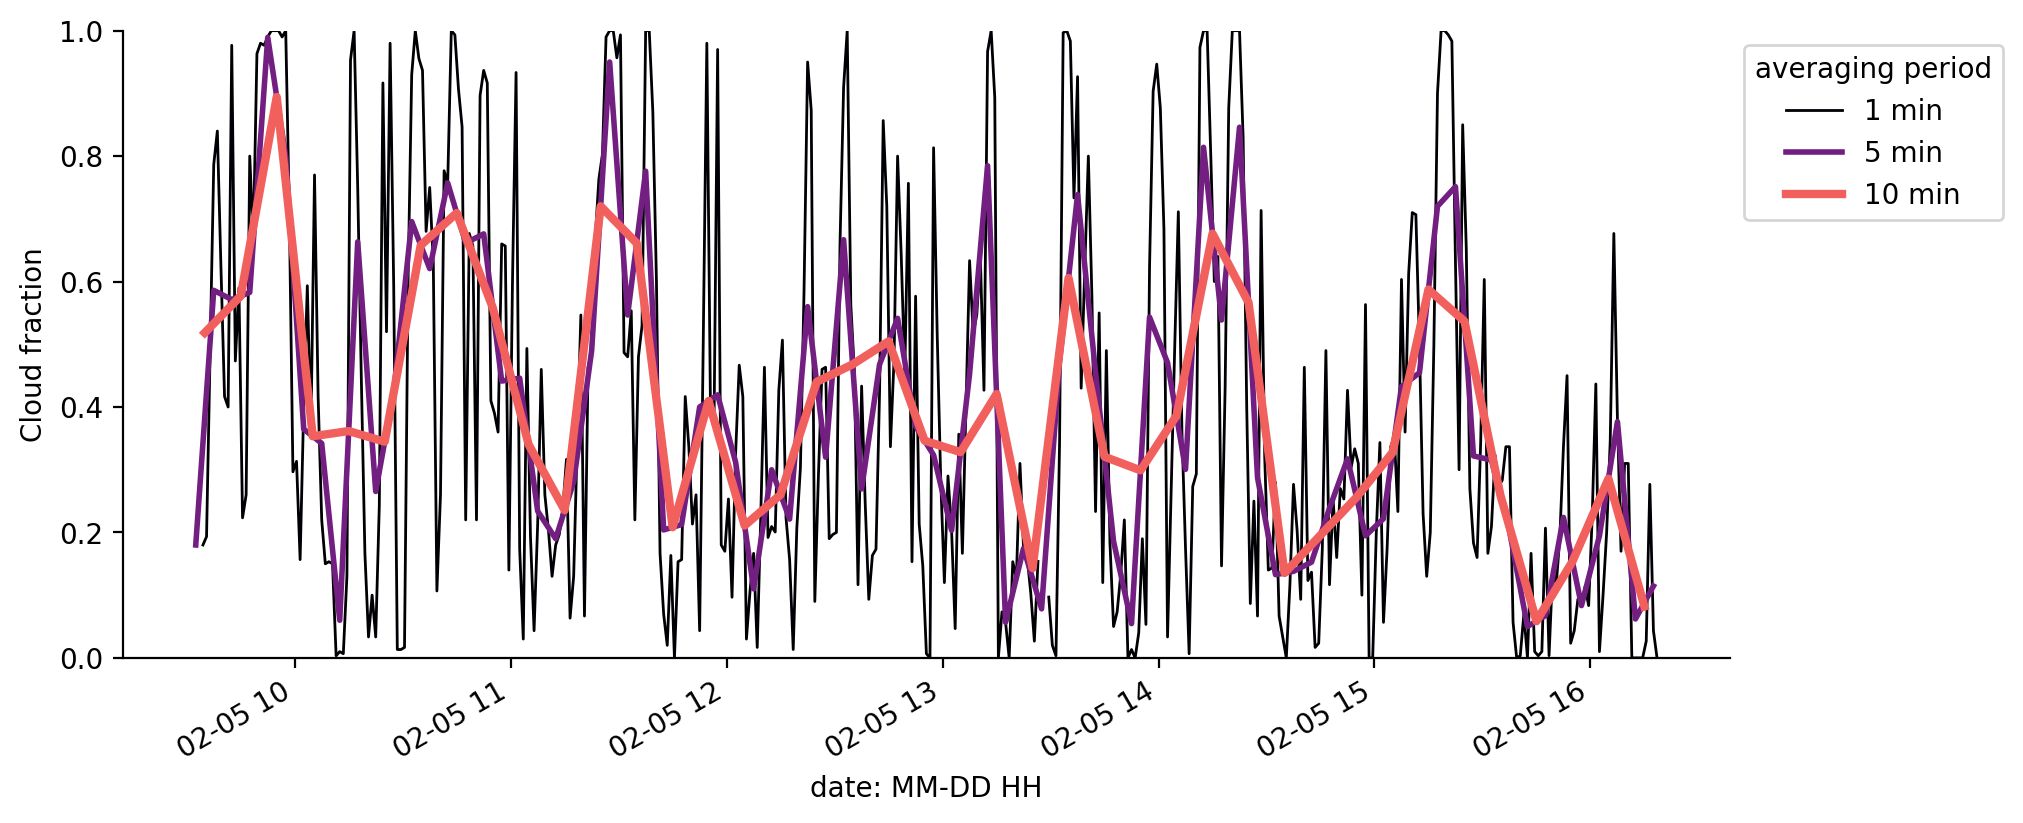

In [9]:
with plt.style.context("mplstyle/wide"):
    fig, ax = plt.subplots()

    ax.set_prop_cycle(color=plt.get_cmap("magma")(np.linspace(0, 1, 4)))
    for ind, t in enumerate([1, 5, 10]):
        averaged_cloud_fraction = min_cloud_binary_mask.resample(time=f"{t}min", loffset=f"{t/2}min").mean()
        averaged_cloud_fraction.plot(lw=ind + 1, label=f"{t} min")

    ax.set_ylim(0, 1)
    ax.set_ylabel("Cloud fraction")
    ax.set_xlabel("date: MM-DD HH")
    ax.legend(title="averaging period", bbox_to_anchor=(1,1), loc="upper left")
    None